In [264]:
import pandas as pd
import os
import csv

In [265]:
def convert_HMD_to_csv(myPath, myFile):
    
    MyFile = os.path.join(myPath, myFile)
    OutFile = myFile[:-3] + "csv"
        
    with open(MyFile) as f:
        HMDfile = f.readlines()[2:]
    
    with open(os.path.join(myPath, OutFile), "w") as csv_file:
        writer = csv.writer(csv_file)            
        for i in range(0, len(HMDfile)):
            writer.writerow(HMDfile[i].split())
    
convert_HMD_to_csv(myPath = "C:/LearnPython/", myFile = "Deaths_1x1.txt")
convert_HMD_to_csv(myPath = "C:/LearnPython/", myFile = "Exposures_1x1.txt")

In [266]:
def wide_to_long(myPath, wideFile):
    
    readFile = os.path.join(myPath, wideFile)
    Name = wideFile.split("_")[0]
    dta = pd.read_csv(readFile)
    df = dta.reset_index()
    longFile = pd.melt(df, id_vars=['Year', "Age"], value_vars=['Female', 'Male', 'Total'],
               var_name='Gender', value_name=Name)
    return longFile

In [267]:
Dx = wide_to_long(myPath = "C:/LearnPython/", wideFile = "Deaths_1x1.csv")
Ex = wide_to_long(myPath = "C:/LearnPython/", wideFile = "Exposures_1x1.csv")
Dx_Ex = Dx.merge(Ex, on = ["Year", "Age", "Gender"])

In [268]:
Dx_Ex["mx"] = Dx_Ex["Deaths"] / Dx_Ex["Exposures"]
Dx_Ex.loc[Dx_Ex["Age"] == "110+", "Age"] = 110
Dx_Ex["Age"] = pd.to_numeric(Dx_Ex["Age"])
Dx_Ex["mx"].fillna(0, inplace=True)

In [269]:
Dx_Ex.tail()

,Year,Age,Gender,Deaths,Exposures,mx
10318,2020,106,Total,139.17,200.50,0.694115
10319,2020,107,Total,66.31,95.80,0.692171
10320,2020,108,Total,31.23,44.18,0.706881
10321,2020,109,Total,14.52,19.15,0.758225
10322,2020,110,Total,10.78,11.15,0.966816


In [270]:
def LifeTable(mx, Gender):
    
    n = len(mx)-1
    ax = [0.5] * n
    
    if any(g == "Female" for g in Gender):
        ax = [0.14] + ax
    
    else:
        ax = [0.13] + ax
    
    qx = np.array(mx)/(1+(1-np.array(ax))*np.array(mx))
    qx[len(qx)-1] = 1
    qx[qx > 1] = 1
    px = 1-qx
    lx = np.cumprod(px) * 100000
    lx = np.concatenate(([100000], lx[:-1]))
    dx = -np.diff(lx)
    dx = np.concatenate((dx, [lx[len(lx)-1]]))
    Lx1 = lx[1:] + np.array(ax[:-1]) * dx[:-1]
    
    if np.array(mx)[-1] == 0:
        open_Lx = 0
    else:    
        open_Lx =  dx[-1] / np.array(mx)[-1]
    
    Lx = np.concatenate((Lx1, [open_Lx]))
    Tx = np.cumsum(Lx[::-1])
    Tx = Tx[::-1]
    ex = Tx/lx
    
    return ex[0]

In [271]:
output = Dx_Ex.groupby(["Year", "Gender"]).apply(lambda x: LifeTable(x["mx"], x["Gender"]))

C:\Users\Markus\AppData\Local\Temp\ipykernel_21992\3379151358.py:30: RuntimeWarning: invalid value encountered in divide
  ex = Tx/lx


In [272]:
df = output.to_frame().reset_index()
df = df.rename(columns={0 : 'e0'})
df.head()

,Year,Gender,e0
0,1990,Female,78.423973
1,1990,Male,71.910877
2,1990,Total,75.350928
3,1991,Female,78.689974
4,1991,Male,72.094956


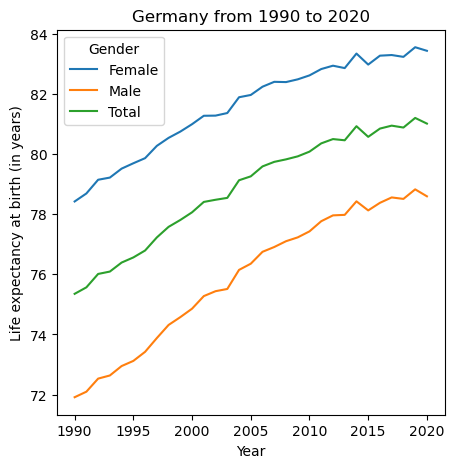

In [273]:
from matplotlib import pyplot as plt

dfplot = df.pivot(index='Year', columns='Gender', values='e0')
dfplot.plot(figsize = (5,5))
plt.ylabel('Life expectancy at birth (in years)')
plt.title("Germany from 1990 to 2020")
plt.savefig('C:/LearnPython/e0_Germany1990to2020.png', dpi=800)